In [1]:
import os, sys
import time
from collections import OrderedDict

import numpy as np
from matplotlib import pyplot as plt

from fmpy import read_model_description, extract

from fmugym import FMUGym, FMUGymConfig, VarSpace, State2Out, TargetValue

import gymnasium as gym

### 1 Implement abstract FMUGym class

In [2]:
class FMUEnv(FMUGym):
    def __init__(self, config):
        self.init_states = {}
        super().__init__(config)

    # Used by step() and reset(), returns any relevant debugging information.
    def _get_info(self):
        return {'info_time':time.time()}

    # Retrieves FMU output values by possibly calling self.fmu_get_fmu_output for handling different FMU versions
    # and stores them in the self.observation dictionary. 
    # It can also add output noise (using self._get_output_noise()) and update the set point 
    def _get_obs(self):
        
        self._get_fmu_output()

        obs = np.array(list(self.observation.values())).flatten()
        
        noisy_observation = obs + self._get_output_noise()

        obs_dict = OrderedDict([
            ('observation', np.array(noisy_observation))
        ])
        return obs_dict

    # Returns input noise for each input component, potentially by sampling from the self.input_noise dictionary.
    def _get_input_noise(self):
        input_noise = []
        for inp_name in self.input_dict:
            noise_mean = self.input_noise[inp_name].low[0]
            noise_std = self.input_noise[inp_name].high[0]
            noise = np.random.normal(noise_mean, noise_std, 1)[0] # if normally distributed noise, implement custom sampling here
            input_noise.append(noise)  
        return np.array(input_noise)

    # Similar to self._get_input_noise, generates output noise for each output component,
    # potentially by sampling from the self.output_noise dictionary.
    def _get_output_noise(self):
        output_noise = []
        for out_name in self.output_dict:
            output_noise.append(self.output_noise[out_name].sample()[0])  # if normally distributed noise, implement custom sampling here
        return np.array(output_noise)

    # Returns two booleans indicating first the termination and second truncation status. 
    def _get_terminated(self):
        if self.time > self.stop_time:
                self.reset()
                return True, False
    
        for termination in self.terminations:
            min_value = self.terminations[termination].low[0]
            max_value = self.terminations[termination].high[0]
            if self.observation[termination] < min_value or self.observation[termination] > max_value:
                self.reset()
                return False, True
                    
        return False, False

    # Constructs the action space from a VarSpace object representing the inputs. 
    # It can use gymnasium.spaces.Box for continuous action spaces.
    def _create_action_space(self, inputs):
        lows = []
        highs = []
        for inp in inputs:
            lows.append(inputs[inp].low[0])
            highs.append(inputs[inp].high[0])
        action_space = gym.spaces.Box(low=np.array(lows), high=np.array(highs), dtype=np.float32)
        return action_space

    # Constructs the observation space returning it as a gymnasium.spaces.Dict. 
    # The observation space typically includes observation, achieved_goal, and desired_goal, each created from a VarSpace object.
    def _create_observation_space(self, outputs):
        lows = []
        highs = []
        for out in outputs:
            lows.append(outputs[out].low[0])
            highs.append(outputs[out].high[0])
        observation_space = gym.spaces.Dict({
            'observation': gym.spaces.Box(low=np.array(lows), high=np.array(highs), dtype=np.float32)
        })
        return observation_space

    # Random variations to initial system states and dynamic parameters by sampling from self.random_vars_refs 
    # and propagates to corresponding initial output values.  
    # It also allows for direct manipulation and randomization of set point goals using the self.y_stop class variable.
    def _noisy_init(self):
        
        # add noise to initial system state
        for var in self.random_vars_refs:
            var_ref = self.random_vars_refs[var][0]
            uniform_value = self.random_vars_refs[var][1].sample()[0]   # if normally distributed noise, implement custom sampling here
            self.init_states[var_ref] = uniform_value
        
        return self.init_states

    # Called by self.step() to add noise to action from RL library.
    # May be used to execute low-level controller and adapt action space.
    def _process_action(self, action):
        processed_action = action + self._get_input_noise()
        return processed_action
    
    # collect current values of randomized parameters with parameter_refs and store them in self.random_vars_refs
    def get_random_vars(self):
        params = {key: self.init_states[value[0]] for key, value in self.random_vars_refs.items()}
        return params
    
    # dummy methods to compy with the FMUGym interface
    def _process_reward(self, obs, acts, info):
        reward = self.compute_reward()
        return reward
    
    def compute_reward(self):
        return np.array([0.0])
    
    def setpoint_trajectory():
        return np.array([0.0])

### 2 Create FMUGymConfig object

In [3]:
# providing inputs, outputs and their noises with range of values
inputs = VarSpace("inputs")
inputs.add_var_box("R1", -2.0, 2.0)
inputs.add_var_box("S2", -2.0, 2.0)
inputs.add_var_box("C4", -2.0, 2.0)
inputs.add_var_box("S4", -2.0, 2.0)
inputs.add_var_box("C5", -2.0, 2.0)
inputs.add_var_box("R4", -2.0, 2.0)
inputs.add_var_box("N2", -2.0, 2.0)

# Input noise is normally distributed with gym.Box with lower bound as mean, higher as standard deviation
input_noise = VarSpace("input_noise") # *2 to account for internal processing (tolerance field) and CETOL comparison
input_noise.add_var_box("R1", 0.0, 0.05/3.0 * 2)
input_noise.add_var_box("S2", 0.0, 0.05/3.0 * 2)
input_noise.add_var_box("C4", 0.0, 0.05/3.0 * 2)
input_noise.add_var_box("S4", 0.0, 0.1/3.0 * 2)
input_noise.add_var_box("C5", 0.0, 0.1/3.0 * 2)
input_noise.add_var_box("R4", 0.0, 0.05/3.0 * 2)
input_noise.add_var_box("N2", 0.0, 0.05/3.0 * 2)

outputs = VarSpace("outputs")
outputs.add_var_box("FR1_min", -1e6, 1e6)
outputs.add_var_box("FR1_max", -1e6, 1e6)
outputs.add_var_box("FR2_min", -1e6, 1e6)
outputs.add_var_box("FR2_max", -1e6, 1e6)

output_noise = VarSpace("output_noise")
output_noise.add_var_box("FR1_min", 0.0, 0.0)
output_noise.add_var_box("FR1_max", 0.0, 0.0)
output_noise.add_var_box("FR2_min", 0.0, 0.0)
output_noise.add_var_box("FR2_max", 0.0, 0.0)

# randomized system parameters and their range of values
random_vars = VarSpace("random_vars")
# randomized initial initial states and their range of values -> not used, we have a static system
# random_vars.add_var_box("firstOrder.y_start", -0.5, 0.5)
# random_vars.add_var_box("firstOrder1.y_start", -0.5, 0.5)

# allowed range of output values, if exceeded termination (or rather truncation) of the episode
terminations = VarSpace("terminations") # for single step simulation, no termination is needed

# create FMUGymConfig object from all the above defined parameters
config = FMUGymConfig(fmu_path=os.path.abspath('FMUs/geom_tol.fmu'),
                      start_time=0.0,
                      stop_time=1.0,                # only simulate one step
                      sim_step_size=1.0,            # only simulate one step
                      action_step_size=1.0,         # only simulate one step
                      inputs=inputs,
                      input_noise=input_noise,
                      outputs=outputs,
                      output_noise=output_noise,
                      random_vars=random_vars,
                      terminations=terminations
                     )         

# 2nd config with no noise

# Input noise is normally distributed with gym.Box with lower bound as mean, higher as standard deviation
no_input_noise = VarSpace("input_noise")
no_input_noise.add_var_box("R1", 0.0, 0.0)
no_input_noise.add_var_box("S2", 0.0, 0.0)
no_input_noise.add_var_box("C4", 0.0, 0.0)
no_input_noise.add_var_box("S4", 0.0, 0.0)
no_input_noise.add_var_box("C5", 0.0, 0.0)
no_input_noise.add_var_box("R4", 0.0, 0.0)
no_input_noise.add_var_box("N2", 0.0, 0.0)         

config_no_noise = FMUGymConfig(fmu_path=os.path.abspath('FMUs/geom_tol.fmu'),
                      start_time=0.0,
                      stop_time=1.0,                # only simulate one step
                      sim_step_size=1.0,            # only simulate one step
                      action_step_size=1.0,         # only simulate one step
                      inputs=inputs,
                      input_noise=no_input_noise,
                      outputs=outputs,
                      output_noise=output_noise,
                      random_vars=random_vars,
                      terminations=terminations
                     )                  

### 3 Creation of FMUEnv instance

In [4]:
dummyEnv = FMUEnv(config)
dummyEnv_no_noise = FMUEnv(config_no_noise)

### 4 Run worst case evaluations

In [5]:
# Nominal simulation
nominal_inputs = np.array([0.1, 0.2, 0.1, 0.1, 0.1, 0.1, 0.2]) 
dummyEnv_no_noise.reset()
observation, reward, terminated, truncated, info = dummyEnv_no_noise.step(nominal_inputs)

worst_case_values = observation["observation"]
worst_case_FR1_max = observation["observation"][0]
worst_case_FR1_min = observation["observation"][1]
worst_case_FR2_max = observation["observation"][2]
worst_case_FR2_min = observation["observation"][3]

print("FR1_max: ", worst_case_FR1_max)
print("FR1_min: ", worst_case_FR1_min)
print("FR2_max: ", worst_case_FR2_max)
print("FR2_min: ", worst_case_FR2_min)

FR1_max:  0.6294316
FR1_min:  0.3705684
FR2_max:  0.35517204
FR2_min:  -0.05517205


### 5 Run stochastic case evaluations

In [6]:
# Stochastic simulation
num_episodes = 500
act_collection = []
obs_collection = []

In [7]:
for iter in range(num_episodes):
    # resetting the environment and setting random initial and target values
    observation, info = dummyEnv.reset()
    # capturing trajectories here
    action = np.zeros(len(nominal_inputs))
    observation, reward, terminated, truncated, info = dummyEnv.step(action)
    obs_collection.append(observation["observation"])
    act_collection.append(nominal_inputs + dummyEnv._get_input_noise())

In [8]:
obs_collection = np.array(obs_collection)
act_collection = np.array(act_collection)

### 6 Plotting the results

In [9]:
# decide whether to load the previously saved data:
obs_collection = np.load("tol_results/obs_collection.npy")
worst_case_values = np.load("tol_results/worst_case_values.npy")

worst_case_FR1_max = worst_case_values[0]
worst_case_FR1_min = worst_case_values[1]
worst_case_FR2_max = worst_case_values[2]
worst_case_FR2_min = worst_case_values[3]

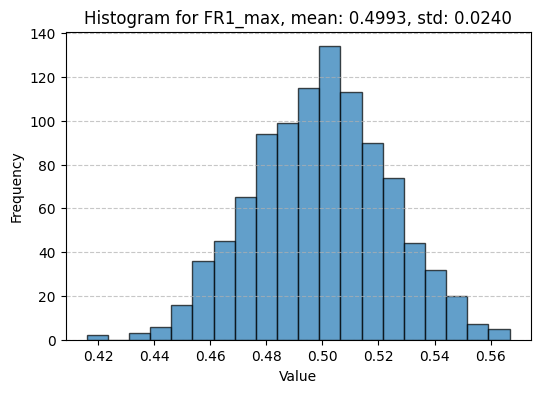

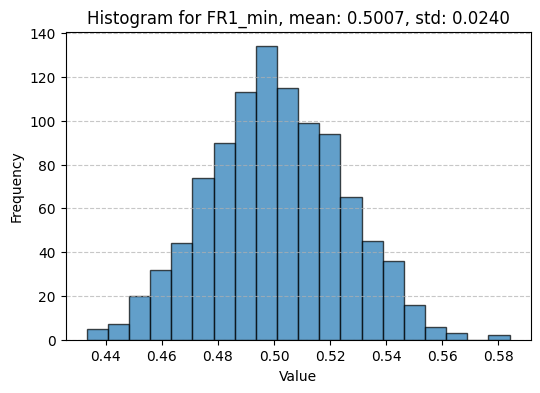

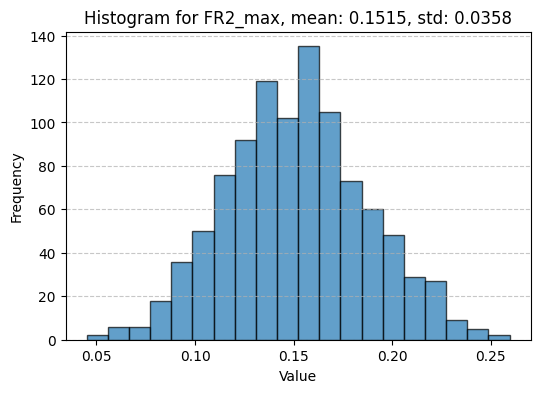

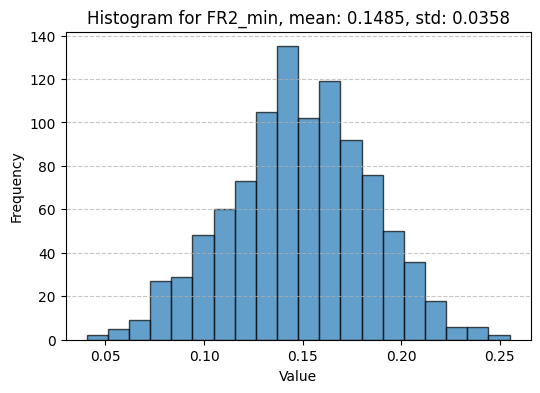

In [10]:
for k in range(len(dummyEnv.output_dict)):
    plt.figure(figsize=(6, 4))
    plt.hist(obs_collection[:, k], bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title(f"Histogram for {list(dummyEnv.output_dict.keys())[k]}, mean: {np.mean(obs_collection[:, k]):.4f}, std: {np.std(obs_collection[:, k]):.4f}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

## Plots for paper

In [11]:
!pip install scipy

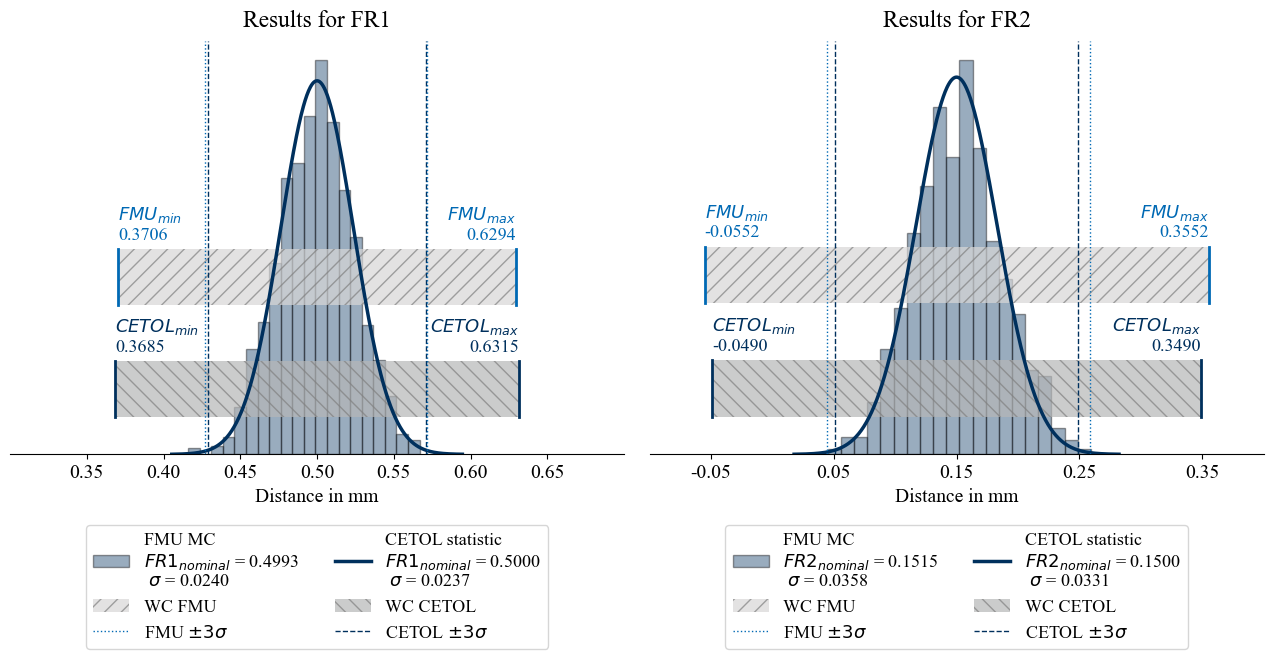

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from scipy.stats import norm

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14

obs_collection = np.load('tol_results/obs_collection.npy')
worst_case_values = np.load('tol_results/worst_case_values.npy')

TUD_BLUE = '#00305D'
TUD_HL_BLUE = '#0069B4'

CETOL_mean = 0.5
CETOL_std = 0.02366
CETOL_wc_min = 0.368458
CETOL_wc_max = 0.631542

FMU_wc_min = worst_case_values[1]
FMU_wc_max = worst_case_values[0]

CETOL_mean_FR2 = 0.15
CETOL_std_FR2 = 0.03307
CETOL_wc_min_FR2 = -0.0489517
CETOL_wc_max_FR2 = 0.348952

FMU_wc_min_FR2 = worst_case_values[3]
FMU_wc_max_FR2 = worst_case_values[2]

fig, axs = plt.subplots(1, 2, figsize=(13, 7))

for i, ax in enumerate(axs):
    if i == 0:
        mean, std, wc_min, wc_max, label = CETOL_mean, CETOL_std, CETOL_wc_min, CETOL_wc_max, 'FR1'
        fmu_min, fmu_max = FMU_wc_min, FMU_wc_max
        data = obs_collection[:, 0]
    else:
        mean, std, wc_min, wc_max, label = CETOL_mean_FR2, CETOL_std_FR2, CETOL_wc_min_FR2, CETOL_wc_max_FR2, 'FR2'
        fmu_min, fmu_max = FMU_wc_min_FR2, FMU_wc_max_FR2
        data = obs_collection[:, 2]

    x = np.linspace(mean - 4*std, mean + 4*std, 500)
    bell_curve = norm.pdf(x, mean, std)

    ax.hist(data, bins=20, density=True, edgecolor='black', alpha=0.4, color=TUD_BLUE,
            label=f'FMU MC\n${label}_{{nominal}}$ = {np.mean(data):.4f}\n $\\sigma$ = {np.std(data):.4f}')

    ax.plot(x, bell_curve, linestyle='-', color=TUD_BLUE, linewidth=2.5,
            label=f'CETOL statistic\n${label}_{{nominal}}$ = {mean:.4f}\n $\\sigma$ = {std:.4f}')

    max_y = max(bell_curve)
    bar_height = max_y * 0.15
    offset = max_y * 0.1

    CETOL_3sigma_min = mean - 3 * std
    CETOL_3sigma_max = mean + 3 * std
    FMU_3sigma_min = np.mean(data) - 3 * np.std(data)
    FMU_3sigma_max = np.mean(data) + 3 * np.std(data)

    ax.axvline(CETOL_3sigma_min, color=TUD_BLUE, linestyle='--', linewidth=1, label='CETOL $\\pm 3\\sigma$')
    ax.axvline(CETOL_3sigma_max, color=TUD_BLUE, linestyle='--', linewidth=1)
    ax.axvline(FMU_3sigma_min, color=TUD_HL_BLUE, linestyle=':', linewidth=1, label='FMU $\\pm 3\\sigma$')
    ax.axvline(FMU_3sigma_max, color=TUD_HL_BLUE, linestyle=':', linewidth=1)

    bar2_bottom = max_y * 0.1
    bar2_top = bar2_bottom + bar_height
    ax.fill_between([wc_min, wc_max], bar2_bottom, bar2_top, color='#B6B7B7', alpha=0.7,
                    hatch='\\\\', edgecolor='grey', linewidth=0, label='WC CETOL')
    ax.plot([wc_min, wc_min], [bar2_bottom, bar2_top], color=TUD_BLUE, linewidth=2)
    ax.plot([wc_max, wc_max], [bar2_bottom, bar2_top], color=TUD_BLUE, linewidth=2)
    ax.text(wc_min, bar2_top + bar_height * 0.1, f"$CETOL_{{min}}$\n{wc_min:.4f}", ha='left', va='bottom', fontsize=13, color=TUD_BLUE)
    ax.text(wc_max, bar2_top + bar_height * 0.1, f"$CETOL_{{max}}$\n{wc_max:.4f}", ha='right', va='bottom', fontsize=13, color=TUD_BLUE)

    bar1_bottom = max_y * 0.3 + offset
    bar1_top = bar1_bottom + bar_height
    ax.fill_between([fmu_min, fmu_max], bar1_bottom, bar1_top, color='#D8D7D7', alpha=0.7,
                    hatch='//', edgecolor='grey', linewidth=0, label='WC FMU')
    ax.plot([fmu_min, fmu_min], [bar1_bottom, bar1_top], color=TUD_HL_BLUE, linewidth=2)
    ax.plot([fmu_max, fmu_max], [bar1_bottom, bar1_top], color=TUD_HL_BLUE, linewidth=2)
    ax.text(fmu_min, bar1_top + bar_height * 0.1, f"$FMU_{{min}}$\n{fmu_min:.4f}", ha='left', va='bottom', fontsize=13, color=TUD_HL_BLUE)
    ax.text(fmu_max, bar1_top + bar_height * 0.1, f"$FMU_{{max}}$\n{fmu_max:.4f}", ha='right', va='bottom', fontsize=13, color=TUD_HL_BLUE)

    ax.set_xlabel('Distance in mm')
    if label == 'FR1':
        # Ticks symmetrisch um 0.5 im Abstand 0.05 ergänzen
        ticks = np.arange(0.5 - 3 * 0.05, 0.5 + 3 * 0.05, 0.05)
        ax.set_xlim(0.5 - 0.2, 0.5 + 0.2)  # Bereich anpassen, z.B. 0.3 bis 0.7
        ax.xaxis.set_major_locator(FixedLocator(ticks))
        labels = [f'{tick:.2f}' for tick in ticks]
        ax.set_xticklabels(labels)
    if label == 'FR2':
        # zentrierte Ticks um 0.15 im Abstand 0.1
        ticks = np.arange(0.15 - 3 * 0.1, 0.15 + 3 * 0.1 + 0.01, 0.1)
        ax.set_xlim(0.15 - 0.25, 0.15 + 0.25)  # z.B. -0.1 bis 0.4
        ax.xaxis.set_major_locator(FixedLocator(ticks))
        # Labels schön formatieren
        labels = [f'{tick:.2f}' for tick in ticks]
        ax.set_xticklabels(labels)
    ax.set_title(f'Results for {label}', pad=10)
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    handles, labels = ax.get_legend_handles_labels()
    cetol_indices = [0, 5, 3]
    fmu_indices = [1, 4, 2]

    new_handles = [handles[i] for i in cetol_indices] + [handles[i] for i in fmu_indices]
    new_labels = [labels[i] for i in cetol_indices] + [labels[i] for i in fmu_indices]

    ax.legend(new_handles, new_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True, fontsize=13)

plt.tight_layout()
plt.savefig('fig_results.pdf', format='pdf', bbox_inches='tight')
plt.show()
